In [4]:
# Import Libraries

import numpy as np
import matplotlib.pyplot as plt

import math, time
import itertools
import datetime
from operator import itemgetter
from math import sqrt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


import pandas as pd
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import Series

from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM


## Load the stock data

### Choose CSV file of the company stock price

In [5]:
# Insert the stock price here 
apple = pd.read_csv('AAPL.csv')

col_names = ['Timestamp','Sequence','Open','High','Low','Close','Volume']
apple.columns = col_names
apple['Timestamp'] =  pd.to_datetime(apple['Timestamp'],format='%Y-%m-%d %H:%M:%S')
apple.index = apple['Timestamp']
apple = apple.drop(['Sequence','Timestamp'],axis =1)
apple.head()

,Open,High,Low,Close,Volume
Timestamp,,,,,
2018-03-12 15:49:00,181.5762,181.750,181.5762,181.6900,48721
2018-03-12 15:50:00,181.6986,181.710,181.5700,181.5745,51915
2018-03-12 15:51:00,181.6600,181.720,181.6400,181.6924,32218
2018-03-12 15:52:00,181.5100,181.675,181.5000,181.6700,62321
2018-03-12 15:53:00,181.7200,181.720,181.5100,181.5200,34506


In [6]:
df = apple[['Close']]

In [7]:
df.head()

,Close
Timestamp,
2018-03-12 15:49:00,181.6900
2018-03-12 15:50:00,181.5745
2018-03-12 15:51:00,181.6924
2018-03-12 15:52:00,181.6700
2018-03-12 15:53:00,181.5200


In [8]:
df = df.loc['2018-03-14']

In [9]:
df.shape

(391, 1)

## Visualisation

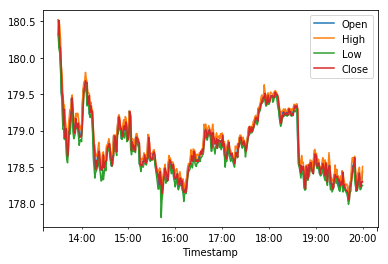

In [10]:
apple = apple.drop(['Volume'],axis=1)
apple.loc['2018-03-14'].plot()

## Spilt the data to train and test

In [11]:
train_data =df.iloc[:-100]

In [12]:
test_data = df.iloc[-100:]

In [13]:
print(train_data.shape)
print(test_data.shape)

(291, 1)
(100, 1)


Text(0,0.5,'Stock Price')

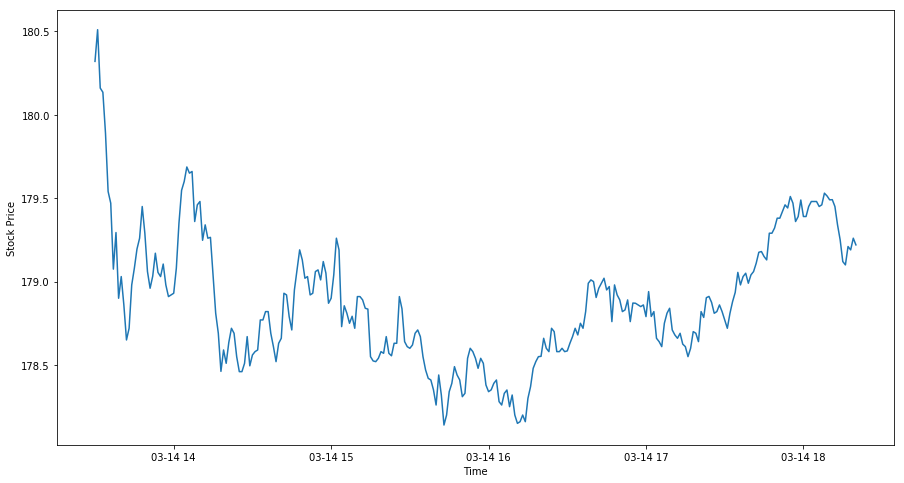

In [14]:
plt.figure(figsize=(15,8))
plt.plot(train_data)
plt.xlabel('Time')
plt.ylabel('Stock Price')

## Function for testing stationarity

In [15]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15, 5));
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    plt.figure(figsize=(15, 5));
    plt.title('Standard Deviation')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['Close'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['open','high','10_Min_volatility', '50_Min_moving_avg'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

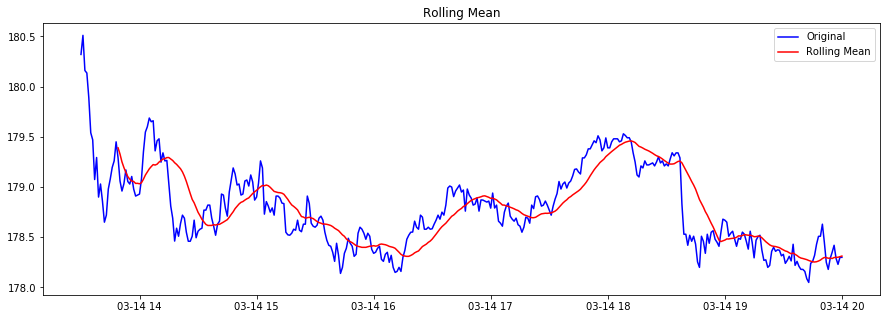

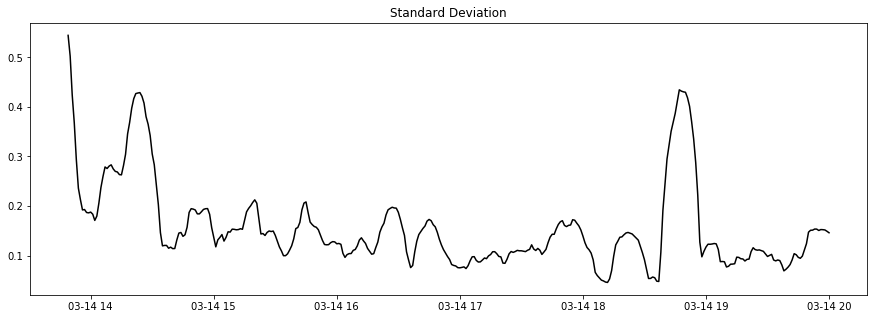

Results of Dickey-Fuller Test:
open                     -3.940814
high                      0.001754
10_Min_volatility         0.000000
50_Min_moving_avg       390.000000
Critical Value (1%)      -3.447229
Critical Value (5%)      -2.868980
Critical Value (10%)     -2.570733
dtype: float64


In [16]:
test_stationarity(df)

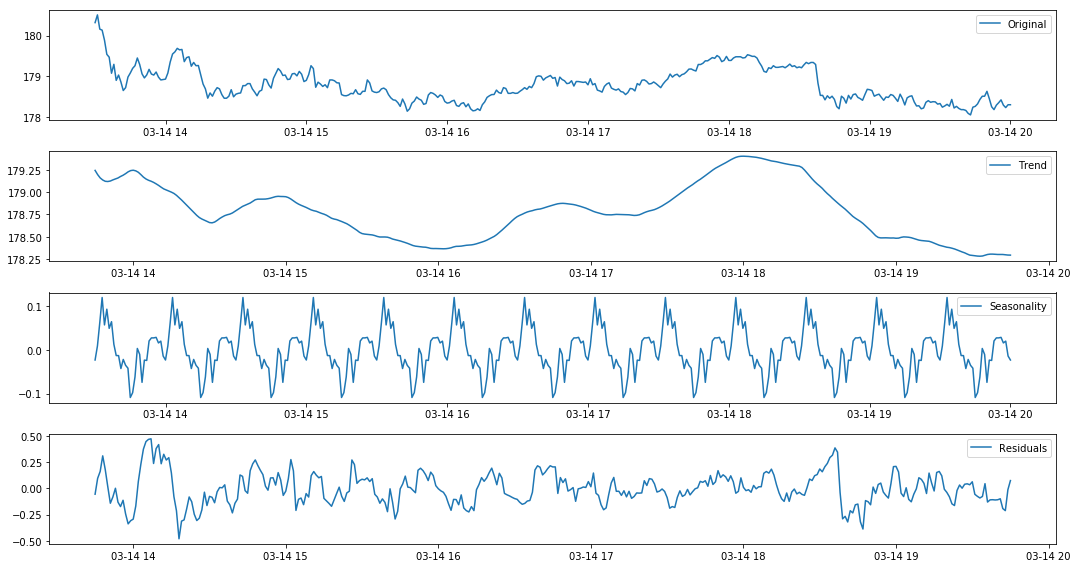

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df, freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(15,8))
plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Modeling

In [18]:
import keras

In [25]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data

class resetStates():
    def on_epoch_end(self, epoch, logs=None):
        self.model.reset_states()

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    #model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=1, shuffle=False,callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min')])

    for i in range(nb_epoch):
        print("Completed :",i+1,"/",nb_epoch, "Steps")
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
        #model.reset_states()

    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
series = train_data["Close"]


# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 3)
supervised_values = supervised.values


# split data into train and test-sets
train, test = supervised_values[0:-1], supervised_values[-1:]


# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)


# fit the model
lstm_model = fit_lstm(train, 1, 200, 3)


# serialize model to JSON
model_json = lstm_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lstm_model.save_weights("model.h5")
print("Saved model to disk")


'''

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)

#train_reshaped = train_scaled[:, 0:15].reshape(len(train_scaled), 1, 15)

prediction_train = lstm_model.predict(train_reshaped, batch_size=1)

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):

    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    #print(X)
    print(yhat)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)

    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)

    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Minute=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-1:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
#plt.figure(figsize=(15,8))
#plt.plot(raw_values[-1:])
#plt.plot(predictions)
#plt.show()
'''

Completed : 1 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.0129
Completed : 2 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0129
Completed : 3 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0129
Completed : 4 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0128
Completed : 5 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0128
Completed : 6 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0128
Completed : 7 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.0128
Completed : 8 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0127
Completed : 9 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0127
Completed : 10 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0127
Completed : 11 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0127
Completed : 12 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0127
Completed : 13 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0126
Completed : 14 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0126
Completed : 15 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0126
Completed : 16 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0126
Completed : 17 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0126
Completed : 18 / 200 St

Completed : 142 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.0116
Completed : 143 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.0116
Completed : 144 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0116
Completed : 145 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.0116
Completed : 146 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0116
Completed : 147 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0116
Completed : 148 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0116
Completed : 149 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0116
Completed : 150 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.0116
Completed : 151 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.0116
Completed : 152 / 200 Steps
Epoch 1/1
 - 1s - loss: 0.0116
Completed : 153 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0116
Completed : 154 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0116
Completed : 155 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0116
Completed : 156 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0116
Completed : 157 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.0116
Completed : 158 / 200 Steps
Epoch 1/1
 - 0s - loss: 0.01

"\n\n# forecast the entire training dataset to build up state for forecasting\ntrain_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)\n\n#train_reshaped = train_scaled[:, 0:15].reshape(len(train_scaled), 1, 15)\n\nprediction_train = lstm_model.predict(train_reshaped, batch_size=1)\n\n# walk-forward validation on the test data\npredictions = list()\nfor i in range(len(test_scaled)):\n\n    # make one-step forecast\n    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]\n    yhat = forecast_lstm(lstm_model, 1, X)\n    #print(X)\n    print(yhat)\n    # invert scaling\n    yhat = invert_scale(scaler, X, yhat)\n\n    # invert differencing\n    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)\n\n    # store forecast\n    predictions.append(yhat)\n    expected = raw_values[len(train) + i + 1]\n    print('Minute=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))\n\n# report performance\nrmse = sqrt(mean_squared_error(raw_values[-1:], predictions))\nprint('Test 

In [20]:
from keras.models import model_from_json

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
lstm_model = model_from_json(loaded_model_json)
# load weights into new model
lstm_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [21]:
test_scaled.shape

(1, 4)

In [22]:
scaler, train_scaled, test_scaled = scale(train, test)
base_value = df.iloc[290].values

prediction = []
for i in range(100):
    
    input_data = test_scaled[:,i:-1]
    input_data = input_data.reshape(input_data.shape[1], 1, 1)
    y_hat = forecast_lstm(lstm_model,1,input_data)
    test_scaled = np.insert(test_scaled,[1],y_hat, axis=1)
    
    temp2 = invert_scale(scaler, input_data, y_hat)
    temp3 = base_value  + temp2
    base_value = temp3
    prediction.append(temp3)

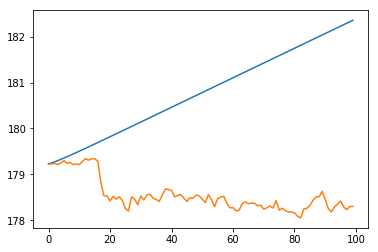

In [23]:
plt.plot(prediction)
plt.plot(test_data.values)

In [24]:
rmse = sqrt(mean_squared_error(test_data.values, prediction))
rmse

2.5360608855314424